In [3]:
import scanpy as sc
import torch
import numpy as np

# Load the mapped data (tangram model)
path = r"..\data\processed\tangram_model.h5ad"
ad_map = sc.read_h5ad(path)


📌 Step 2: Prepare Data for Training
We'll use the mapped data (ad_map.X) as input (X). Now, let’s say the target (y) is some spatially relevant biological label you want to predict (e.g., cell proliferation score, immune activity, etc.).

In [5]:
# Extract gene expression data from the mapped data
# X = torch.tensor(ad_map.X.toarray(), dtype=torch.float32)
X = torch.tensor(ad_map.X, dtype=torch.float32)


# Generate fake labels for demonstration purposes
# Replace this with your actual labels if available
np.random.seed(42)
y = torch.tensor(np.random.rand(X.shape[0], 1), dtype=torch.float32)  # Random values between 0 and 1


📌 Step 3: Define the Deep Learning Model (FNN Example)
We'll define a basic Feedforward Neural Network (FNN) that learns from the spatially mapped data.

In [6]:
import torch.nn as nn

class SpatialActivityPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SpatialActivityPredictor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
            nn.Sigmoid()  # Use Softmax if multiclass
        )
    
    def forward(self, x):
        return self.model(x)


📌 Step 4: Train the Model

In [7]:
# Hyperparameters
input_size = X.shape[1]  # Number of genes
hidden_size = 128
output_size = 1  # Single activity prediction
learning_rate = 0.001
num_epochs = 20

# Initialize model, loss function, and optimizer
model = SpatialActivityPredictor(input_size, hidden_size, output_size)
criterion = nn.BCELoss()  # Use nn.CrossEntropyLoss() if multiclass
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    
    # Forward pass
    outputs = model(X)
    loss = criterion(outputs, y)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [5/20], Loss: 0.6932
Epoch [10/20], Loss: 0.6932
Epoch [15/20], Loss: 0.6931
Epoch [20/20], Loss: 0.6931


📌 Step 5: Evaluate & Visualize Results
Now, let’s visualize the predicted activity levels on the spatial tissue.

In [58]:
visium_data.obsm['spatial'][:, 0].shape

(3858,)

In [59]:
visium_data.obsm['spatial'][:, 1].shape

(3858,)

In [60]:
predictions.shape

(3500,)

In [ ]:
spatial_data = visium_data.obsm['spatial']
spatial_data

In [63]:


# Reduce both dimensions to 3500
reduced_spatial_x = spatial_data[:3500, 0]  # First 3500 elements of the first column
reduced_spatial_y = spatial_data[:3500, 1]  # First 3500 elements of the second column

In [65]:
print(reduced_spatial_x.shape)  # Should be (3500,)
print(reduced_spatial_y.shape)  # Should be (3500,)
print(predictions.shape)          # Should also be (3500,)

(3500,)
(3500,)
(3500,)


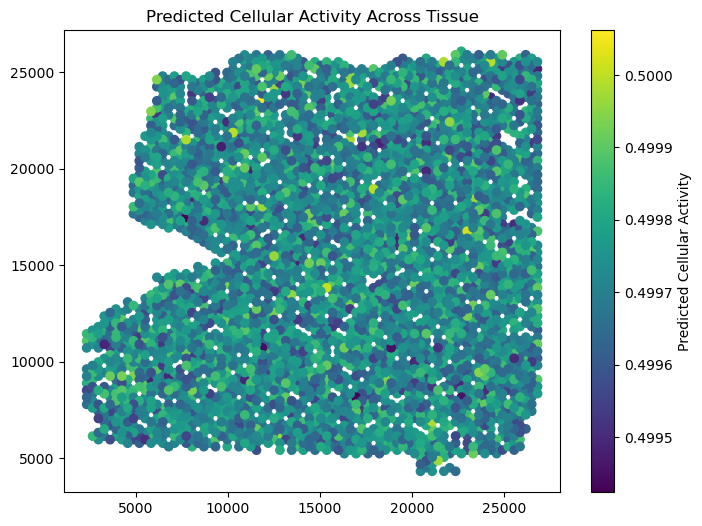

In [64]:
plt.figure(figsize=(8, 6))
plt.scatter(reduced_spatial_x, reduced_spatial_y, c=predictions.flatten())
plt.colorbar(label='Predicted Cellular Activity')
plt.title('Predicted Cellular Activity Across Tissue')
plt.show()


In [ ]:
print(ad_map.obsm.keys())


KeysView(AxisArrays with keys: )


In [15]:
import scanpy as sc

visium_path  = r"..\data\raw\visium_raw\Human_Lung.h5"
# visium_data = sc.read_h5ad(visium_path)

# Load the raw Visium data
visium_data = sc.read_10x_h5(visium_path)  # Replace with your file path

# Check if it loaded correctly
print(visium_data)


c:\Users\iqram\.conda\envs\integration\Lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 3858 × 18085
    var: 'gene_ids', 'feature_types', 'genome'


c:\Users\iqram\.conda\envs\integration\Lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [16]:
# Check available keys
print(visium_data.obs.keys())


Index([], dtype='object')


visium file does not contain keys , The spatial coordinates



In [36]:
import pandas as pd
import numpy as np
import scanpy as sc

# Load your Visium dataset
visium_data = sc.read('../data/processed/processed_visium_adata.h5ad')

# visium_path  = r"..\data\raw\visium_raw\Human_Lung.h5"
# visium_data = sc.read_10x_h5(visium_path)  # Replace with your file path

# Load tissue position file
tissue_position_path = r"..\data\raw\visium_raw\CytAssist_FFPE_Human_Lung_Squamous_Cell_Carcinoma_spatial (1)\spatial\tissue_positions.csv"
tissue_positions = pd.read_csv(tissue_position_path, header=0)


# Ensure barcode matching
valid_positions = tissue_positions[tissue_positions['in_tissue'] == 1]

# Making sure barcodes match
visium_barcodes = visium_data.obs.index.tolist()
tissue_positions['barcode'] = tissue_positions['barcode'].str.strip()

# Filter valid_positions to include only matching barcodes
valid_positions = valid_positions[valid_positions['barcode'].isin(visium_barcodes)]

# Dictionary for spatial coordinates
barcode_to_coords = dict(zip(valid_positions['barcode'], 
                             valid_positions[['pxl_row_in_fullres', 'pxl_col_in_fullres']].values))

# Generate ordered spatial coordinates matching visium_data.obs
ordered_spatial_coords = np.array([
    barcode_to_coords[barcode] if barcode in barcode_to_coords else [np.nan, np.nan]
    for barcode in visium_barcodes
])

# Check if there are any unmatched barcodes
missing_count = np.isnan(ordered_spatial_coords).sum()
if missing_count > 0:
    print(f"⚠️ Warning: {missing_count} barcodes have missing spatial coordinates.")

# Attach the spatial data to the AnnData object
visium_data.obsm['spatial'] = ordered_spatial_coords

print("✅ Spatial coordinates successfully added to visium_data!")


✅ Spatial coordinates successfully added to visium_data!


In [37]:
print(tissue_positions.columns)


Index(['barcode', 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres',
       'pxl_col_in_fullres'],
      dtype='object')


In [41]:
# Check available keys
print(visium_data.obs.keys())


Index([], dtype='object')


In [40]:
print(visium_data)



AnnData object with n_obs × n_vars = 3858 × 18085
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'spatial'


In [42]:
print(visium_data.obs.index)  # Should show the barcodes


Index(['AACACGTGCATCGCAC-1', 'AACACTTGGCAAGGAA-1', 'AACAGGATTCATAGTT-1',
       'AACAGGTTATTGCACC-1', 'AACAGGTTCACCGAAG-1', 'AACAGTCAGGCTCCGC-1',
       'AACAGTCCACGCGGTG-1', 'AACATAGTCTATCTAC-1', 'AACATCTTAAGGCTCA-1',
       'AACATGCGCAAGTGAG-1',
       ...
       'TGTTCATAGTATGACG-1', 'TGTTCATTGGTCCAAG-1', 'TGTTCCTCACATTAAT-1',
       'TGTTCTGCTCTGTCGT-1', 'TGTTGCGTCCAAGATT-1', 'TGTTGGAACCTTCCGC-1',
       'TGTTGGAACGAGGTCA-1', 'TGTTGGAAGCTCGGTA-1', 'TGTTGGATGGACTTCT-1',
       'TGTTGGCCAGACCTAC-1'],
      dtype='object', length=3858)


📌 Step 6: Save the Model

In [71]:

torch.save(model.state_dict(), 'cell_activity_predictor.pth')


## END 
